In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
!unzip /content/drive/MyDrive/FQW/waste_data.zip -d waste

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_3682.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_4252.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_5968.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_7309.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_5513.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_2775.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_7130.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_3053.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_4524.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_1197.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_6513.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_2582.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_494.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle_3863.jpg  
  inflating: waste/waste_data/TRAIN/Recycle/Recycle

In [12]:
import numpy as np
import torch
import pickle

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook

import torch.nn as nn

from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelEncoder


from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [13]:
!nvidia-smi
torch.cuda.is_available()

Mon May 10 21:32:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [14]:
# разные режимы датасета 
DATA_MODES = ['train', 'test', 'val']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# работаем на видеокарте
DEVICE = torch.device("cuda")

In [64]:
class WasteDataset(Dataset):
    """ 
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
      super().__init__()
      self.files = sorted(files)
      self.mode = mode

      if self.mode not in DATA_MODES:
        print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
        raise NameError

      self.len_ = len(self.files)
      
      self.label_encoder = LabelEncoder()

      if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
      """ Загрузка изображения """
      image = Image.open(file).convert('RGB')
      image.load()
      return image

    def _prepare_sample(self, image):
        """ Корретировка размера изображения """
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

    def __getitem__(self, index):
      transform = {
          'train': transforms.Compose([
              transforms.RandomResizedCrop(244),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]),
          'test': transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(244),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      }

      x = self.load_sample(self.files[index])
      x = self._prepare_sample(x)

      if self.mode == 'test':
        x = transform['test'](x)
      else:
        x = transform['train'](x)

      if self.mode == 'test':
        return x
      else:
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """ Imshow для тензоров """
  
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)

    if title is not None:
        plt.title(title)
    plt_ax.grid(False)

In [16]:
TRAIN_DIR = Path('/content/waste/waste_data/TRAIN')
TEST_DIR = Path('/content/waste/waste_data/TEST')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)


In [65]:
train_dataset = WasteDataset(train_files, mode='train')

val_dataset = WasteDataset(val_files, mode='val')

test_dataset = WasteDataset(test_files, mode='test')

Посмотрим, что лежит в тестовом датасете

In [70]:
random_characters = int(np.random.uniform(0,1000))
im_train, label = val_dataset[random_characters]
im_train, label

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

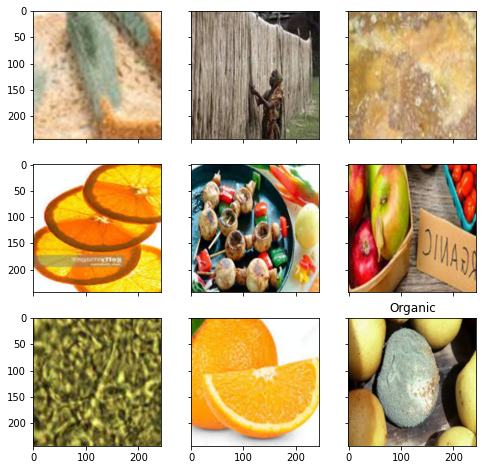

In [71]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Построение нейросети
Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и дальнейшего эксперементирования с learning rate

Описание слоев:

    размерность входа: 3x224x224
    размерности после слоя: 8x111x111
    16x54x54
    32x26x26
    64x12x12
    выход: 96x5x5


In [26]:
class SimpleCnn(nn.Module):
  """ Очень простая сверточная сеть """

  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.out = nn.Linear(96 * 5 * 5, n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits

In [27]:
def fit_epoch(model, train_loader, criterion, optimazer, scheduler):
  """ Обучение модели  c настройкой весов"""
  
  scheduler.step()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0

  # Итерация по бачам
  for inputs, labels in train_loader:
    # Обертка переменных для забуска на видео карте
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Инициализируем градиенты параметров
    optimazer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # backward pass и оптимизация
    loss.backward()
    optimazer.step()
    preds = torch.argmax(outputs, 1)

    # Подсчет статистики 
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data

  return train_loss, train_acc

In [28]:
def eval_epoch(model, val_loader, criterion):
  """ Этап валидации для промежуточной оценки качества обучения модели"""

  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0

  # Итерация по бачам
  for inputs, labels in val_loader:
      # Обертка переменных для забуска на видео карте
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)

      # Проходимся по всей моедли, но уже не корректируем веса
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)

      # Подсчет статистики 
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      processed_size += inputs.size(0)

  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size

  return val_loss, val_acc
      

In [29]:
def train(train_files, val_files, model, epochs, batch_size):
  """ Обучение модели на батчах с определенным количеством эпох """

  # Разделение множества данных на батчи
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  best_model_wts = model.state_dict()
  best_acc = 0.0

  history = []
  log_template =  "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    # Оптимизационный алгоритм (подсчет и изменения градиента)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Метод вычисления точности результата (доствоверности), оптимизируемая функция
    criterion = nn.CrossEntropyLoss()

    # Уменьшение шага градиента в 10 раз
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

    # Итерируемся по эпохам 
    for epoch in range(epochs):
      # Обучение
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, \
                                        exp_lr_scheduler)

      # Проверка
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      
      # Если достиглось лучшее качество, то запомним веса модели
      if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

      history.append((train_loss, train_acc, val_loss, val_acc))
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, \
                                     v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
  print(f'Best val accurancy: {best_acc}')
  model.load_state_dict(best_model_wts)

  return model, history

In [30]:
def predict(model, test_loader):
  """ Тестирование и измерение точности модели """

  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

  probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
  return probs


# Обучение на разных моделях


Обучение на cамой простой сети

In [31]:
# Определение гиперпараметров
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=3, bias=True)
)

In [90]:
# Обучение
model, history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=16)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:  10%|█         | 1/10 [03:09<28:23, 189.28s/it]


Epoch 001 train_loss: 0.5283   val_loss 0.5057 train_acc 0.8032 val_acc 0.8119


epoch:  20%|██        | 2/10 [06:18<25:14, 189.28s/it]


Epoch 002 train_loss: 0.5136   val_loss 0.4979 train_acc 0.8063 val_acc 0.8149


epoch:  30%|███       | 3/10 [09:29<22:07, 189.70s/it]


Epoch 003 train_loss: 0.5072   val_loss 0.5143 train_acc 0.8119 val_acc 0.8077


epoch:  40%|████      | 4/10 [12:40<19:00, 190.11s/it]


Epoch 004 train_loss: 0.5020   val_loss 0.4828 train_acc 0.8124 val_acc 0.8247


epoch:  50%|█████     | 5/10 [15:49<15:48, 189.75s/it]


Epoch 005 train_loss: 0.4942   val_loss 0.4702 train_acc 0.8168 val_acc 0.8283


epoch:  60%|██████    | 6/10 [18:56<12:36, 189.10s/it]


Epoch 006 train_loss: 0.4915   val_loss 0.4626 train_acc 0.8186 val_acc 0.8312


epoch:  70%|███████   | 7/10 [22:03<09:25, 188.52s/it]


Epoch 007 train_loss: 0.4721   val_loss 0.4641 train_acc 0.8239 val_acc 0.8322


epoch:  80%|████████  | 8/10 [25:11<06:16, 188.30s/it]


Epoch 008 train_loss: 0.4688   val_loss 0.4627 train_acc 0.8289 val_acc 0.8368


epoch:  90%|█████████ | 9/10 [28:19<03:08, 188.03s/it]


Epoch 009 train_loss: 0.4658   val_loss 0.4625 train_acc 0.8281 val_acc 0.8283


epoch: 100%|██████████| 10/10 [31:26<00:00, 188.68s/it]


Epoch 010 train_loss: 0.4687   val_loss 0.4675 train_acc 0.8273 val_acc 0.8285
Best val accurancy: 0.8367797630997792


In [91]:
loss, acc, val_loss, val_acc = zip(*history)

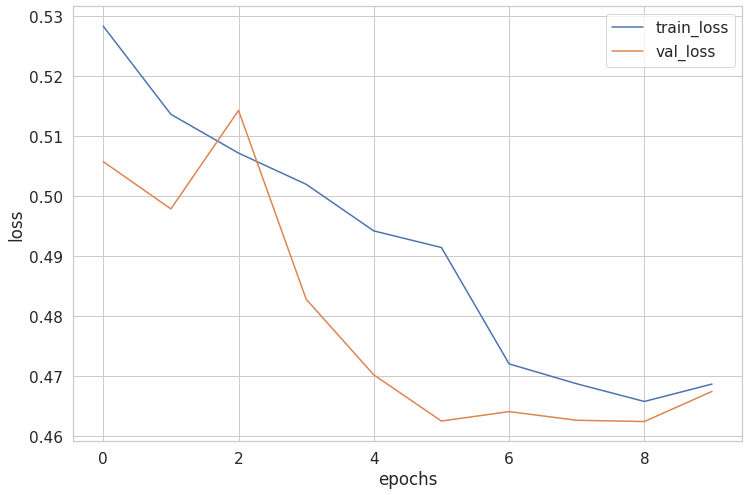

In [92]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


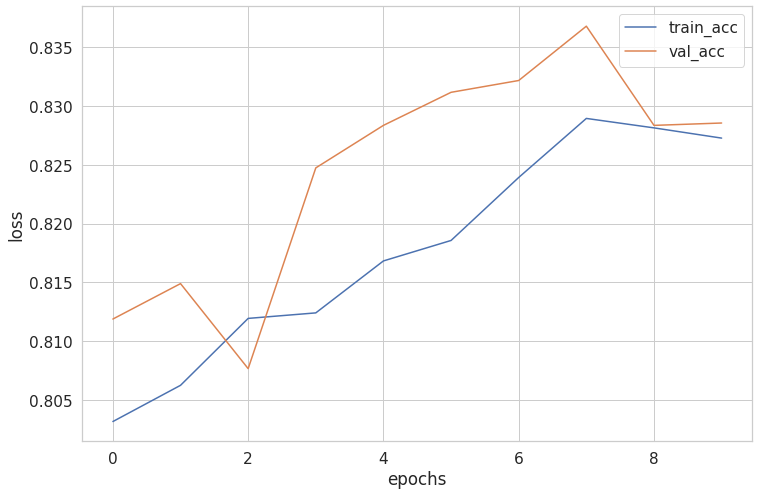

In [93]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [104]:
torch.save(model.state_dict(), 'Simple_cnn.pth')
model.load_state_dict(torch.load('Simple_cnn.pth'))

<All keys matched successfully>

In [105]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [107]:
print(f'Accurancy: {predict(model, test_loader=test_loader)}')

FileNotFoundError: ignored

In [95]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [96]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [97]:

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [98]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [99]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.8000000000000002

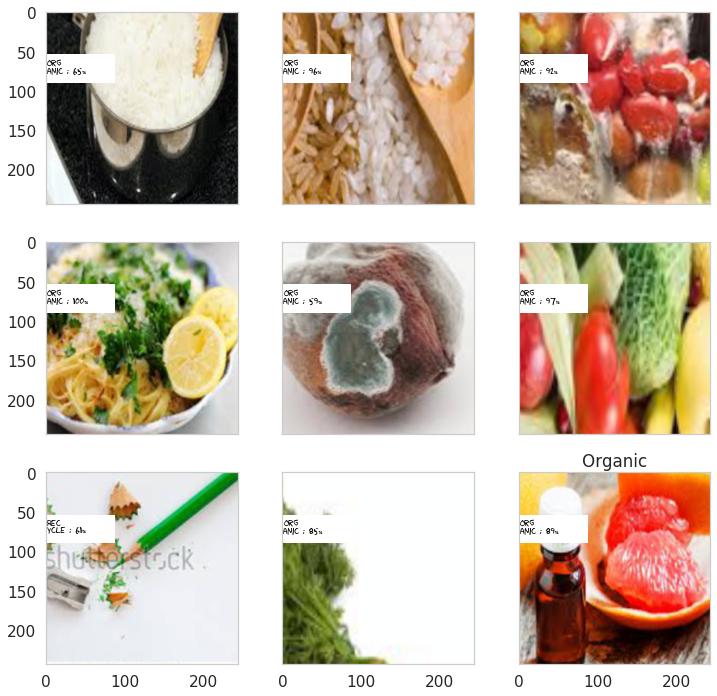

In [101]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [102]:
test_dataset = WasteDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

FileNotFoundError: ignored

In [103]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('submit_2.csv', index=False)
my_submit.head()

,Id,Expected
0,Organic_0.jpg,Organic
1,Organic_1.jpg,Organic
2,Organic_10.jpg,Organic
3,Organic_100.jpg,Organic
4,Organic_1000.jpg,Organic
